In [1]:
#https://gorelick.medium.com/fast-er-downloads-a2abd512aa26

import ee
import requests
import os
import shutil
import tqdm.notebook as tqdm

  
ee.Initialize(opt_url='https://earthengine-highvolume.googleapis.com',project='ee-seasonal-snow-cover')


In [2]:
import rioxarray as rio
import pyproj 
popgrid = rio.open_rasterio('pop2021.tif',band_as_variable=True).band_1
crs='EPSG:3035' #popgrid.rio.crs
transformer = pyproj.transformer.Transformer.from_crs(crs,"epsg:4326", always_xy=True)

In [3]:
import numpy as np
np.random.seed(0)
N=200
Nlarge=100000
x = np.random.randint(0, popgrid.shape[1], Nlarge)
y = np.random.randint(0, popgrid.shape[0], Nlarge)

p = popgrid.data[y,x]
ix = np.where(p>100)[0]
ix = ix[:N]

#p=p[y[ix],x[ix]]
x=popgrid.x.data[x[ix]]
y=popgrid.y.data[y[ix]]
p = p[ix]

points = [[float(x),float(y),int(p)] for x,y,p in zip(x,y,p)]
len(points)

200

In [4]:
from retry import retry

folder=os.path.abspath('tiles/')

#@retry(tries=10, delay=1, backoff=2)
def getResult(index, point):
  
  """Handle the HTTP requests to download an image."""

  # Generate the desired image from the given point.
  #filename = f'{folder}/{point[0]/1000:.0f}_{point[1]/1000:.0f}_pop{point[2]:.0f}.tif'

  pixelsize = 20 #meter
  tilewidth = 5000 #meter
  point[0] = np.floor(point[0]/tilewidth)*tilewidth
  point[1] = np.floor(point[1]/tilewidth)*tilewidth
  filename = f'{folder}/{int(tilewidth/1000)}km_{int(point[0]/1000)}_{int(point[1]/1000)}.tif'
  if os.path.exists(filename):
    print("Already exists: ", filename)
    return
  
  Npixels = int(tilewidth/pixelsize)
  corner_w = point[0] # + pixelsize/2
  corner_s = point[1] # + pixelsize/2
  corner_e = corner_w + tilewidth #- pixelsize
  corner_n = corner_s + tilewidth #- pixelsize
  region = ee.Geometry.Rectangle([
    ee.Geometry.Point((corner_w, corner_s),proj=crs),  
    ee.Geometry.Point((corner_e, corner_n),proj=crs)
  ], proj=crs, evenOdd=False)
  
  image = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') #('LANDSAT/LC08/C02/T1')
           .filterBounds(region)
           .filterDate('2019', '2023') #more years to get more stable stats
           .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',20))
           .filter(ee.Filter.calendarRange(6,10,'month')) #get rid of snowy season (and reduce memory usage)
           .median()
           .select('B1','B2','B3','B4','B5','B6','B7','B8','B8A','B11','B12')
           .clip(region))

  # Fetch the URL from which to download the image.
  url = image.getDownloadURL({
      'region': region,
      'crs':crs,
      'dimensions': f'{Npixels}x{Npixels}',
      'format': 'GEO_TIFF'})

  # Handle downloading the actual pixels.
  r = requests.get(url, stream=True)
  if r.status_code != 200:
    print("Error: ", index, point, r.text)
    raise r.raise_for_status()

  with open(filename, 'wb') as out_file:
    shutil.copyfileobj(r.raw, out_file)
  print("Done: ", index, filename) 

In [5]:
for j in tqdm.tqdm(range(len(points))): #optional:use multiprocessing instead
    getResult(j, points[j])

  0%|          | 0/200 [00:00<?, ?it/s]

Done:  0 c:\Users\ag\Documents\Python\pop_europe\tiles/5km_4395_3320.tif
Done:  1 c:\Users\ag\Documents\Python\pop_europe\tiles/5km_5490_2880.tif
Done:  2 c:\Users\ag\Documents\Python\pop_europe\tiles/5km_4570_4230.tif
Done:  3 c:\Users\ag\Documents\Python\pop_europe\tiles/5km_3900_2390.tif
Done:  4 c:\Users\ag\Documents\Python\pop_europe\tiles/5km_5340_1980.tif
Done:  5 c:\Users\ag\Documents\Python\pop_europe\tiles/5km_4380_4375.tif
Done:  6 c:\Users\ag\Documents\Python\pop_europe\tiles/5km_3960_3120.tif
Done:  7 c:\Users\ag\Documents\Python\pop_europe\tiles/5km_3170_1610.tif
Done:  8 c:\Users\ag\Documents\Python\pop_europe\tiles/5km_4615_3765.tif
Done:  9 c:\Users\ag\Documents\Python\pop_europe\tiles/5km_4940_3060.tif
Done:  10 c:\Users\ag\Documents\Python\pop_europe\tiles/5km_3955_3200.tif
Done:  11 c:\Users\ag\Documents\Python\pop_europe\tiles/5km_4705_2670.tif
Done:  12 c:\Users\ag\Documents\Python\pop_europe\tiles/5km_5675_2695.tif
Done:  13 c:\Users\ag\Documents\Python\pop_europ

C:\Users\ag\AppData\Local\Temp\ipykernel_20488\540018568.py:12: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


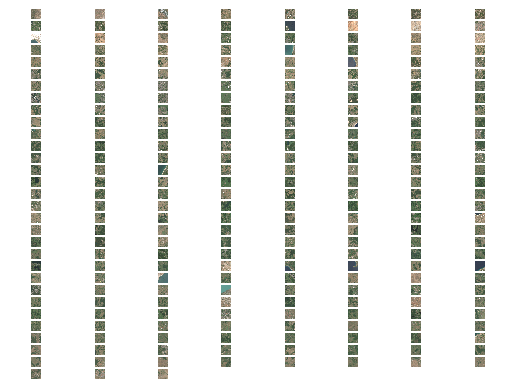

In [6]:
import glob
import matplotlib.pyplot as plt
files=glob.glob('tiles/*.tif')
for ix,file in enumerate(files):
    plt.subplot(int(len(files)/8+.99),8,ix+1)
    ds = rio.open_rasterio(file)
    np.sqrt(np.minimum(ds[3:0:-1,:,:]/3500,1)).plot.imshow()
    plt.axis('off')
    plt.axis('equal')
    plt.title('')
    #1/0
plt.tight_layout()